In [1]:
import json
import os
import pandas as pd
import pprint
import time
import numpy as np

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.callbacks import EarlyStopping


try:
  from pyforest import *
except:
  !pip install pyforest
  from pyforest import *

print(tf.test.gpu_device_name())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.
W0906 11:02:17.244297 140283328857984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0906 11:02:17.254387 140283328857984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0906 11:02:17.258598 140283328857984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0906 11:02:17.279226 140283328857984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17458716717330843138
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5593277146160118877
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1884338423276488055
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6230687059824516588
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


## ConvLSTM Encoder-Decoder Model With Univariate Input

In [2]:
#from google.colab import files

#uploaded = files.upload()

!wget https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/dumps/q_p_list.pickle
    
with open("q_p_list.pickle", "rb") as infile:
  S=pickle.load(infile)
!rm q_p_list.pickle
S1=S[1]
#S1.head()

S1=pd.Series(S1)
S_series=[pd.Series(elem) for elem in S]
scaler = MinMaxScaler(feature_range=(0,1))
S1 = scaler.fit_transform(S1.values.reshape(-1,1))

S=[scaler.fit_transform(S1.values.reshape(-1,1)) for S1 in S_series]

#plt.plot(S1)
X_train, X_test, y_train, y_test = train_test_split(S1[:-1], S1[1:], test_size=0.33, random_state=None, shuffle=False)

--2019-09-06 11:02:20--  https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/dumps/q_p_list.pickle
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3283745 (3.1M) [application/octet-stream]
Saving to: ‘q_p_list.pickle’

q_p_list.pickle     100%[===================>]   3.13M  4.83MB/s    in 0.6s    

2019-09-06 11:02:21 (4.83 MB/s) - ‘q_p_list.pickle’ saved [3283745/3283745]



In [3]:
plt.plot(X_train[:50])
plt.plot(y_train[:50])

In [0]:
#Callback function for online plot while fitting

from IPython.display import clear_output


class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        n_step=10
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses)%n_step==0:
            
            %matplotlib inline
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            #plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            #plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [0]:
def split_multi_sequence(seq_list, n_steps, n_target_serie,n_add_seas=None):
    try:
      from tqdm import tqdm
    except:
      !pip install tqdm
      from tqdm import tqdm
    main_X, main_y, X, y = list(), list(), list(),list()
    target_seq=seq_list[n_target_serie]
    append=True
    for i in tqdm(range(len(target_seq))):
        X=[]
        for sequence in seq_list:
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                append=False
                break
            else:
                append=True
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], target_seq[end_ix]
            if n_add_seas is not None:
              np.append(seq_x, sequence[end_ix-n_add_seas])
            X.append(np.array(seq_x))
            y.append(seq_y)
        if append==True:
            main_X.append(np.array(X))
            main_y.append(seq_y)
    #return np.array(X), np.array(y)
    return main_X, main_y

In [0]:
def shaper(X):
    arr=np.ndarray(shape=(len(X),X[0].shape[1],X[0].shape[0]))
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            for k in range(arr.shape[2]):
                    try:
                        arr[i][j][k]=X[i][k][j]
                    except Exception as e:
                        print(e)
                        print(i,j,k)
                        #break
    return arr

In [7]:
# choose a number of time steps
n_steps = 24
n_target_serie=0
n_seasonality=None
# split into samples
X, y = split_multi_sequence([elem[:-200] for elem in S], n_steps,n_target_serie,n_seasonality)
# reshape from [samples, timesteps] into [samples, timesteps, features]
#X=np.ndarray(X, shape=(len(X), X[0].shape[1], len(X)))

n_features = 51
#X = X.reshape((X.shape[0], X.shape[1], n_features))
#X = X.reshape((X.shape[0], X[0].shape[1], n_features))
X=shaper(X)
y=np.array(y)
#X
#y[0]

Xt, yt=split_multi_sequence([elem[-200:] for elem in S], n_steps, n_target_serie,n_seasonality)
Xt=shaper(Xt)
#Xt = Xt.reshape((Xt.shape[0], Xt.shape[1], n_features))
#yt=S1[-100+1:]

100%|██████████| 200/200 [00:00<00:00, 1146.32it/s]


In [0]:
define=False
if define:
  # define model
  model = Sequential()
  model.add(LSTM(204, activation='relu', input_shape=(n_steps, n_features),return_sequences=True, dropout=0.1))
  model.add(LSTM(units=51, activation='relu', return_sequences=True,dropout=0.1))
  model.add(LSTM(units=30, activation='relu',dropout=0.1))
  model.add(Dense(units=128, activation="relu"))
  model.add(Dense(units=30, activation="relu"))
  model.add(Dense(units=1, activation="sigmoid"))
  #model.add(Activation("sigmoid"))
  #model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer())#, metrics=["acc"])
  model.compile(loss='mae', optimizer="adam", metrics=["acc","mae"])

# fit model

In [9]:
#model.fit(X, y, epochs=100,  verbose=2,shuffle=False, callbacks=[plot_losses])#EarlyStopping(monitor='val_loss', patience=50)])
model.fit(X, y, epochs=100, batch_size=256, verbose=2,shuffle=False, callbacks=[plot_losses])#EarlyStopping(monitor='val_loss', patience=50)])

#model.fit(X, y, epochs=2000, verbose=0,shuffle=False,validation_split=0.2,callbacks=[plot_losses, EarlyStopping(monitor='val_loss', patience=100)])

NameError: ignored

In [10]:
n_test=168
ypt = model.predict(Xt[:n_test], verbose=0)
yrt = yt[:n_test]

yp = model.predict(X[50:100], verbose=0)
yr = y[50:100]


plt.figure(figsize=(12,12))
n=100
plt.plot(yp, color= 'red', label="Predicted")
plt.plot(yr, color='green', label="Real")

plt.plot(range(len(yp),len(yp)+len(ypt)),ypt,color="red", label="TPredicted")
plt.plot(range(len(yp),len(yp)+len(yrt)),yrt,color="green",  label="TReal")

plt.legend()
plt.show()

NameError: ignored

In [11]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, GRU, CuDNNLSTM
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Nadam
from time import time
#!pip install livelossplot
#from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

look_back=n_steps
def create_model():
    model = Sequential()
    model.add(CuDNNLSTM(51, input_shape=(look_back, n_features), return_sequences=True, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.05))
    
    #1
    for _ in range(2):
        model.add(CuDNNLSTM(51, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.05))   

    #2
    model.add(CuDNNLSTM(25, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.1))
    
    #3
    for _ in range(0):
        model.add(Dense(4, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.1))
    #3
    for _ in range(8):
        model.add(Dense(128, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))
    #4
    for _ in range(1):
        model.add(Dense(51, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.1))

    #5
    model.add(Dense(25, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.1))
        
    model.add(Dense(1))
    
    return model
  
model=create_model()




W0906 11:03:02.247431 140283328857984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 11:03:03.143915 140283328857984 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
epochs = 10**2
bs = 512
lr = 1e-1

# 0.05 0.9 0 True
#sgd = SGD(lr=0.5, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower
adam = Adam(lr=lr)
nadam = Nadam(lr=lr)

# compile & fit
model.compile(optimizer='adam', loss = ['mse'], metrics=["mae", 'mse'])



W0906 11:03:07.898756 140283328857984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



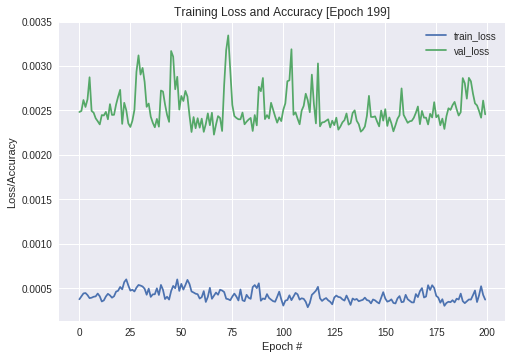

In [30]:
model.fit(X, y, epochs=200, batch_size=1024, validation_split=0.2,
         verbose=0, callbacks=[plot_losses])
#print(model.summary())

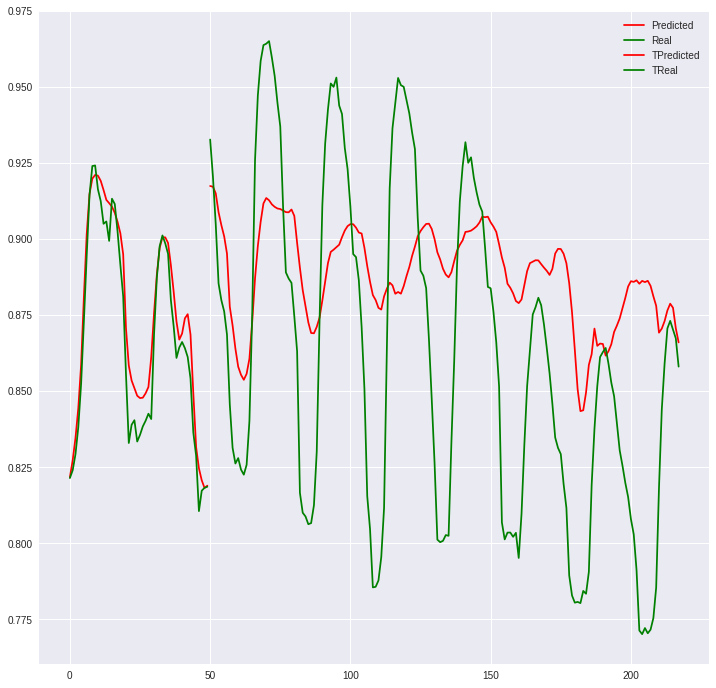

In [31]:
n_test=168
ypt = model.predict(Xt[:n_test], verbose=0)
yrt = yt[:n_test]

yp = model.predict(X[50:100], verbose=0)
yr = y[50:100]


plt.figure(figsize=(12,12))
n=100
plt.plot(yp, color= 'red', label="Predicted")
plt.plot(yr, color='green', label="Real")

plt.plot(range(len(yp),len(yp)+len(ypt)),ypt,color="red", label="TPredicted")
plt.plot(range(len(yp),len(yp)+len(yrt)),yrt,color="green",  label="TReal")

plt.legend()
plt.show()

In [0]:
score, acc = model.evaluate(X[50:100], y[50:100],batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

50/50 [==============================] - 5s 98ms/step
Test score: 0.00605501833371818
Test accuracy: 0.0


In [0]:
from keras.models import model_from_json
save=False

colab=True
if colab:
  model_name="LSTM_multivar_unidim"
else:
  model_name="lstm_models/LSTM_multivar_unidim"
model_weights=model_name+"_weigths.h5"
    
if save:
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_weights)
    print("Saved model to disk")
    if colab:
        from google.colab import files
        files.download(model_name+".json")
        files.download(model_weights)

# later...
load=False
colab=True
if load:
  if colab:
    from google.colab import files
    files.upload()
  json_file = open(model_name+".json", 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
  loaded_model.load_weights(model_weights)
  print("Loaded model from disk")

recompile=False
if recompile:
    loaded_model.compile(loss='mse', optimizer="adam")
    model=loaded_model

W0905 17:57:57.056302 140424811452288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

